In [ ]:
pip install tensorflow scikit-learn imageio matplotlib torchvision imbalanced-learn scipy pandas seaborn plotly

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.6 MB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, random
import seaborn as sns
import warnings
import shutil
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
import keras.applications.resnet_v2 as resnet_v2

from plotly.subplots import make_subplots
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import imageio.v3 as imageio

warnings.simplefilter('ignore')
print("Versi Tensorflow: ", tf.__version__)


Versi Tensorflow:  2.15.0


# Inisialisasi Dataset
Menggunakan kelas ImageFolder dari modul torchvision.datasets gambar dimuat dari direktori 'dataset/original' dan dilakukan transformasi. Gambar diubah ukurannya menjadi (32, 32) piksel dan diubah menjadi tensor menggunakan modul transforms. Terakhir, kelas-kelas yang ada dalam dataset ditampilkan untuk memberikan gambaran mengenai kategori label.

In [ ]:
transformer = T.Compose([T.Resize((32, 32)), T.ToTensor()])
dataset = ImageFolder(Path('dataset/original'), transform = transformer)

print(dataset.classes)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


# Exploratory Data Analysis
EDA merupakan proses investigasi awal terhadap data untuk mendapatkan pemahaman yang lebih baik tentang karakteristiknya. Pada tahap ini dilakukan analisis terhadap distribusi kelas dalam dataset, sehingga dapat dilakukan pemrosesan data lebih lanjut untuk kasus yang membutuhkan.

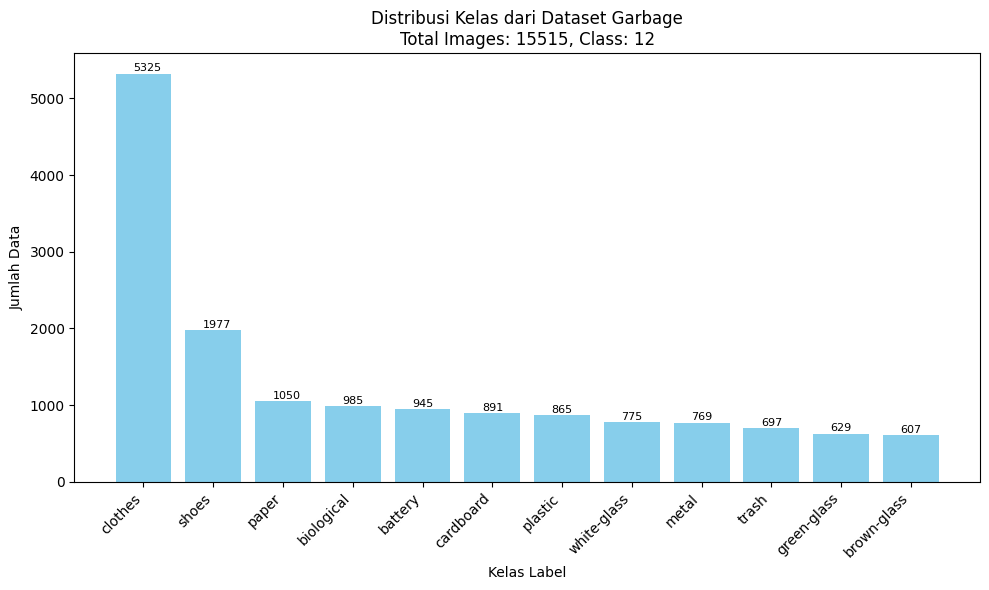

In [ ]:
# Hitung jumlah data pada setiap kelas
class_labels = dataset.classes
class_counts = [dataset.targets.count(label_idx) for label_idx in range(len(class_labels))]

# Urutkan label kelas berdasarkan jumlah datanya
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k], reverse=True)
sorted_class_labels = [class_labels[i] for i in sorted_indices]
sorted_class_counts = [class_counts[i] for i in sorted_indices]

# Plot diagram batang untuk memvisualisasikan distribusi kelas
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_labels, sorted_class_counts, color='skyblue')

for bar, count in zip(bars, sorted_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.006 * max(sorted_class_counts), str(count), fontsize=8)

# Hitung total gambar dan kelas dari dataset yang digunakan
total_images = sum(sorted_class_counts)
num_classes = len(sorted_class_labels)

plt.xlabel('Kelas Label')
plt.ylabel('Jumlah Data')
plt.title(f'Distribusi Kelas dari Dataset Garbage\nTotal Images: {total_images}, Class: {num_classes}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Sample dataset images for each class: 


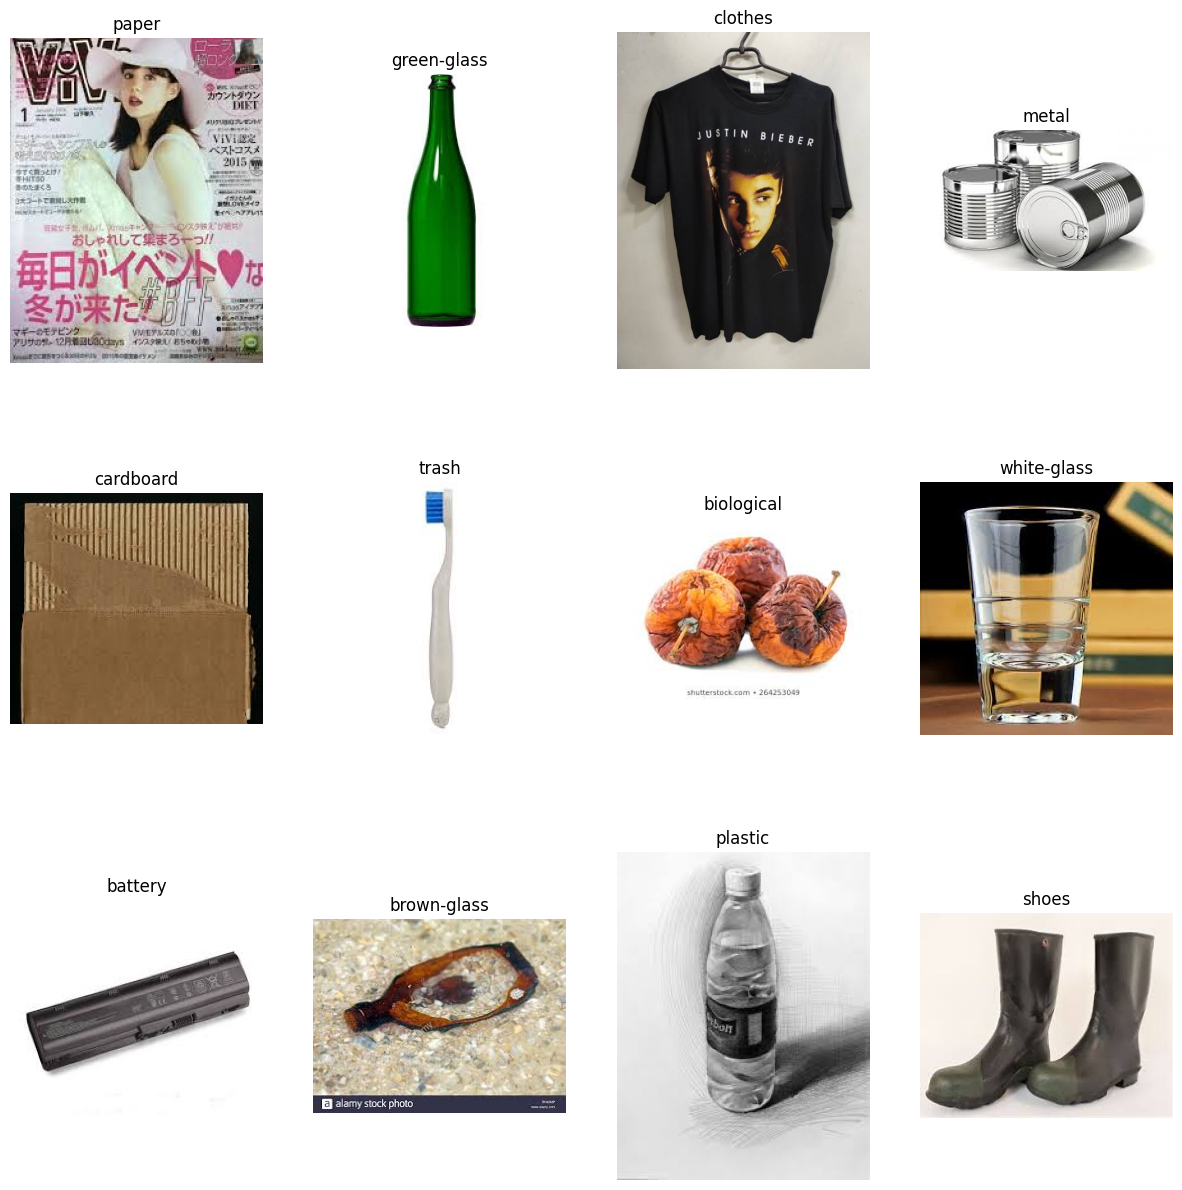

In [ ]:
import os
import random
import matplotlib.pyplot as plt

def img_examples(path, num_rows=3, num_cols=4):
    print('Sample dataset images for each class: ')
    
    plt.figure(figsize=(15, 15))

    classes = [folder for folder in os.listdir(path) if not folder.startswith('.') and os.path.isdir(os.path.join(path, folder))]
    total_classes = len(classes)
    max_subplots = num_rows * num_cols
    num_plots = min(total_classes, max_subplots)

    for i in range(num_plots):
        folder = classes[i]
        directory = os.path.join(path, folder)

        # Using os.scandir for efficient directory listing
        img_files = [entry.path for entry in os.scandir(directory) if entry.is_file() and entry.name.endswith(('.jpg', '.jpeg', '.png'))]

        if img_files:
            random_img_path = random.choice(img_files)

            # Using imageio.v2 to read images
            img = imageio.imread(random_img_path)

            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(img)
            plt.title(folder)
            plt.axis("off")

    plt.show()

# Example usage
img_examples('dataset/original', num_rows=3, num_cols=4)


# Data Remediation

Data remediation adalah proses identifikasi, evaluasi, dan perbaikan data yang tidak akurat, tidak lengkap, atau tidak sesuai dengan standar tertentu. Tujuan utama dari data remediation adalah memastikan integritas dan kualitas data dalam suatu sistem atau organisasi. Proses ini dilakukan di Processed folder untuk menjaga dataset original

In [ ]:
import os
import shutil

def make_processed_folder(original_path, processed_path):
    try:
        # Check if the original folder exists
        if not os.path.exists(original_path):
            raise FileNotFoundError(f"Original folder not found: {original_path}")

        # Create the processed folder if it doesn't exist
        if not os.path.exists(processed_path):
            os.makedirs(processed_path)

        # Traverse the original folder and copy each subfolder to the processed folder
        for root, dirs, files in os.walk(original_path):
            relative_path = os.path.relpath(root, original_path)
            destination_path = os.path.join(processed_path, relative_path)

            # Create the destination folder if it doesn't exist
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)

            # Copy files to the destination folder
            for file in files:
                source_file_path = os.path.join(root, file)
                destination_file_path = os.path.join(destination_path, file)
                shutil.copy2(source_file_path, destination_file_path)

        print(f"Folders copied successfully from {original_path} to {processed_path}")

    except Exception as e:
        print(f"Error: {e}")

original_folder_path = "dataset/original"
processed_folder_path = "dataset/processed"

make_processed_folder(original_folder_path, processed_folder_path)


Folders copied successfully from dataset/original to dataset/processed


## Merging Folds
Tahap ini ditujukan untuk menggabungkan kelas dengan fungsi, material, warna, atau bentuk yang serupa. Proses dilakukan dengan function merge_and_remove_folders

In [ ]:
import os
import shutil

def merge_and_remove_folders(base_path, class_folders, merged_class_name):
    merged_class_path = os.path.join(base_path, merged_class_name)
    
    # Buat folder gabungan jika belum ada
    os.makedirs(merged_class_path, exist_ok=True)

    for folder in class_folders:
        directory = os.path.join(base_path, folder)

        for file in os.listdir(directory):
            source = os.path.join(directory, file)
            destination = os.path.join(merged_class_path, file)

            # Pindah data dari folder masing masing kelas ke folder gabungan
            shutil.move(source, destination)

        # Hapus folder yang osong
        os.rmdir(directory)

# Base path untuk proses ini adalah folder processed
base_path = 'dataset/processed/'

### Merging Green Glass, White Glass, Brown Glass
Tiga kelas kaca ini memiliki material, fungsi, dan, bentuk yang sama, hanya saja memiliki warna yang berbeda. Terlebih, pada kasus klasifikasi sampah untuk daur ulang, warna tidak memiliki pengaruh signifikan. Untuk itu, ketiga kelas ini dapat di merge menjadi satu kelas 'glass'

In [ ]:
merge_and_remove_folders(base_path, ['green-glass', 'white-glass', 'brown-glass'], 'glass')

### Merging Paper dan Cardboard
Kedua kelas ini, yaitu cardboard dan paper terbuat dari material yang sama, dan bentuk yang serupa sehingga dapat diklasifikasikan sebagai satu kelas. juga, pada kasus klasifikasi sampah yang digunakan untuk daur ulang, kertas dan kardus tidak dipisahkan secara khusus.

In [ ]:
merge_and_remove_folders(base_path, ['paper', 'cardboard'], 'cardboard-and-paper')

## Dropping Folds
Kelas "trash" bersifat ambigu, dan folder tersebut memiliki citra sampah dengan material dan bentuk yang berbeda. Untuk itu, kelas ini akan dihapus.

In [ ]:
shutil.rmtree(os.path.join(processed_folder_path, 'trash'))

In [ ]:
transformer = T.Compose([T.Resize((32, 32)), T.ToTensor()])
dataset = ImageFolder(Path('dataset/processed'), transform = transformer)

print(dataset.classes)

['battery', 'biological', 'cardboard-and-paper', 'clothes', 'glass', 'metal', 'plastic', 'shoes']


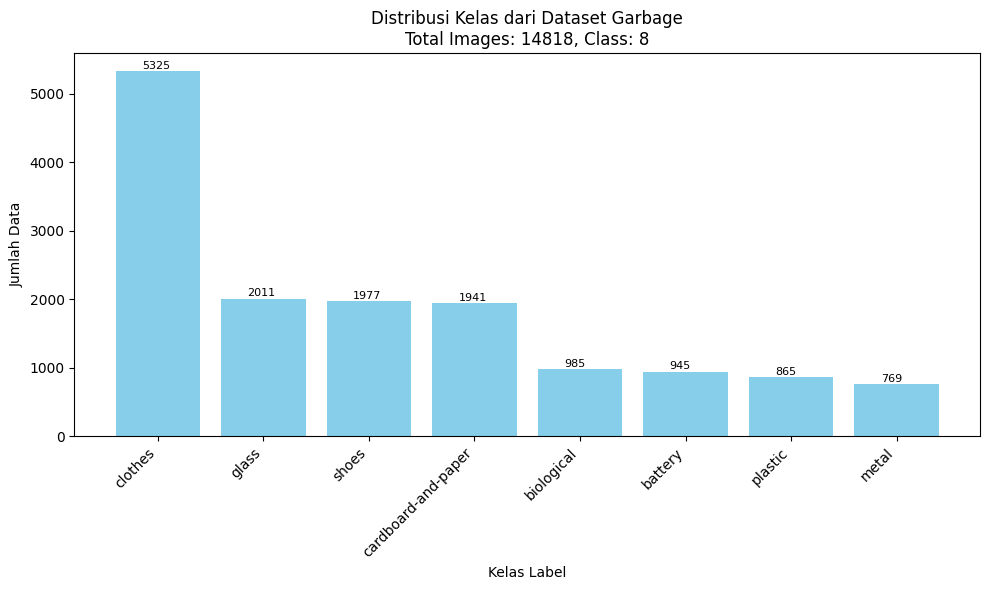

In [ ]:
# Hitung jumlah data pada setiap kelas
class_labels = dataset.classes
class_counts = [dataset.targets.count(label_idx) for label_idx in range(len(class_labels))]

# Urutkan label kelas berdasarkan jumlah datanya
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k], reverse=True)
sorted_class_labels = [class_labels[i] for i in sorted_indices]
sorted_class_counts = [class_counts[i] for i in sorted_indices]

# Plot diagram batang untuk memvisualisasikan distribusi kelas
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_labels, sorted_class_counts, color='skyblue')

for bar, count in zip(bars, sorted_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.006 * max(sorted_class_counts), str(count), fontsize=8)

# Hitung total gambar dan kelas dari dataset yang digunakan
total_images = sum(sorted_class_counts)
num_classes = len(sorted_class_labels)

plt.xlabel('Kelas Label')
plt.ylabel('Jumlah Data')
plt.title(f'Distribusi Kelas dari Dataset Garbage\nTotal Images: {total_images}, Class: {num_classes}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Sample dataset images for each class: 


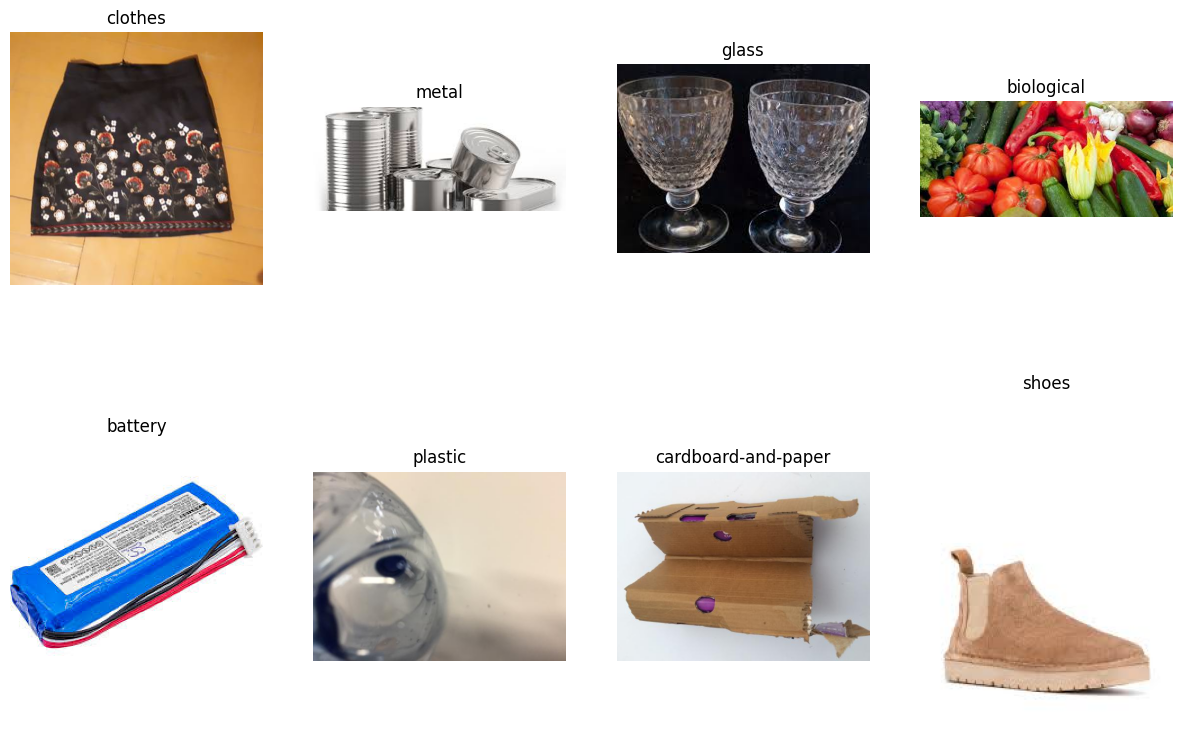

In [ ]:
img_examples('dataset/processed', num_rows=3, num_cols=4)

## Imbalanced Data
Berdasarkan visualisasi bar chart, terlihat bahwa distribusi data antar kelas masih tidak seimbang. Misalnya, dataset clothes memiliki 5325 data sedangkan plastic memiliki 865 data. Untuk itu, perlu dilakukan teknik undersampling, sehingga proporsi antar kelas dapat diatur ulang agar lebih seimbang. Teknik ini dapat membantu model machine learning untuk mengatasi masalah ketidakseimbangan data dan meningkatkan kinerjanya dalam mengenali kelas minoritas. Undersampling digunakan untuk mengambil sampel acak dari setiap kelas sebanyak 769 data, sehingga jumlah sampel seluruh kelas menjadi seimbang dengan kelas minoritas yaitu metal dengan jumlah sampel 769 data.

In [ ]:
import os
import random
import shutil

# Desired number of data points per folder
desired_data_points = 769

# Desired number of data points per folder
desired_data_points = 769

# Iterate through each class folder
for class_folder in os.listdir(processed_folder_path):
    class_folder_path = os.path.join(processed_folder_path, class_folder)

    # Check if the current item is a directory
    if os.path.isdir(class_folder_path):
        # List all files in the current class folder
        files = os.listdir(class_folder_path)

        # Check if the number of files is greater than the desired number of data points
        if len(files) > desired_data_points:
            # Randomly shuffle the list of files
            random.shuffle(files)

            # Keep only the first 'desired_data_points' files
            selected_files = files[:desired_data_points]

            # Delete the excess files
            for file in files:
                if file not in selected_files:
                    file_path = os.path.join(class_folder_path, file)
                    os.remove(file_path)

            print(f'{class_folder} - Undersampled: {len(selected_files)} data points')
        else:
            print(f'{class_folder} - No undersampling needed')
    else:
        print(f'{class_folder} - Not a directory (skipped)')

print('Undersampling complete.')

.DS_Store - Not a directory (skipped)
clothes - Undersampled: 769 data points
metal - No undersampling needed
glass - Undersampled: 769 data points
biological - Undersampled: 769 data points
battery - Undersampled: 769 data points
plastic - Undersampled: 769 data points
cardboard-and-paper - Undersampled: 769 data points
shoes - Undersampled: 769 data points
Undersampling complete.


In [ ]:
transformer = T.Compose([T.Resize((32, 32)), T.ToTensor()])
dataset = ImageFolder(Path('dataset/processed'), transform = transformer)

print(dataset.classes)

['battery', 'biological', 'cardboard-and-paper', 'clothes', 'glass', 'metal', 'plastic', 'shoes']


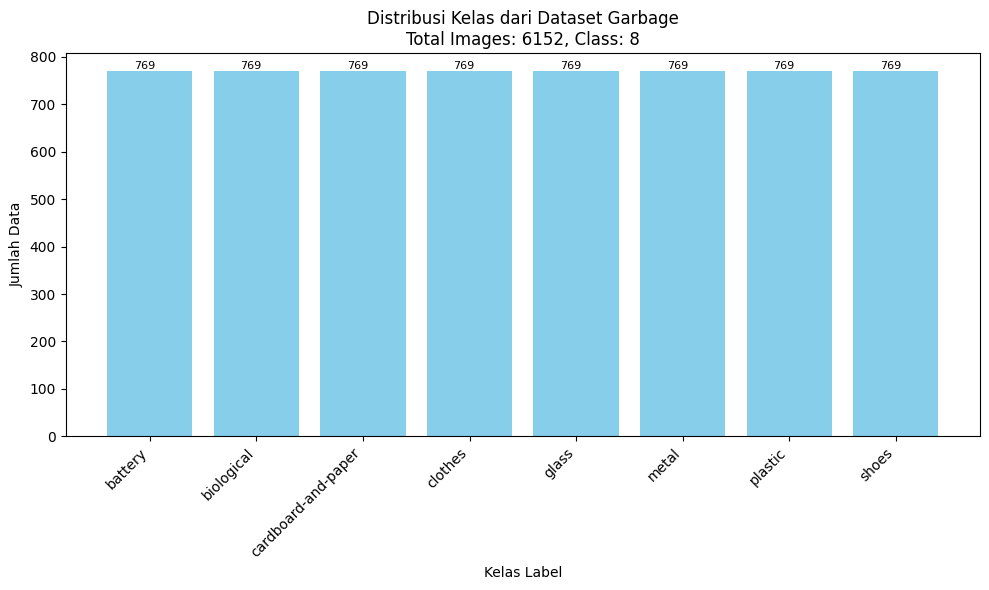

In [ ]:
# Hitung jumlah data pada setiap kelas
class_labels = dataset.classes
class_counts = [dataset.targets.count(label_idx) for label_idx in range(len(class_labels))]

# Urutkan label kelas berdasarkan jumlah datanya
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k], reverse=True)
sorted_class_labels = [class_labels[i] for i in sorted_indices]
sorted_class_counts = [class_counts[i] for i in sorted_indices]

# Plot diagram batang untuk memvisualisasikan distribusi kelas
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_labels, sorted_class_counts, color='skyblue')

for bar, count in zip(bars, sorted_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.006 * max(sorted_class_counts), str(count), fontsize=8)

# Hitung total gambar dan kelas dari dataset yang digunakan
total_images = sum(sorted_class_counts)
num_classes = len(sorted_class_labels)

plt.xlabel('Kelas Label')
plt.ylabel('Jumlah Data')
plt.title(f'Distribusi Kelas dari Dataset Garbage\nTotal Images: {total_images}, Class: {num_classes}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Sample dataset images for each class: 


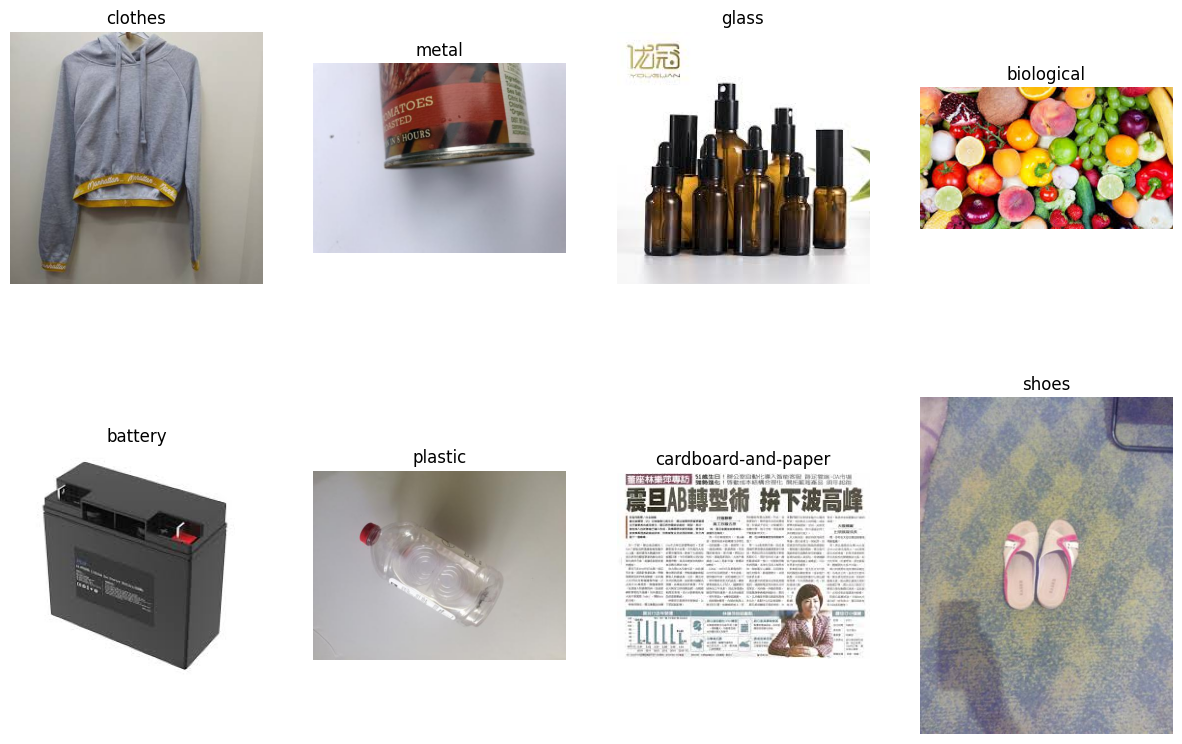

In [ ]:
img_examples('dataset/processed', num_rows=3, num_cols=4)

## Data Augmentation
Teknik augmentasi yang ditentukan melibatkan rotasi secara random, pergeseran citra secara horizontal dan vertikal, zooming, flipping secara horizontal, dan penyesuaian kecerahan secara random. Transformasi ini diterapkan untuk memperkaya dataset pelatihan, meningkatkan kemampuan model secara umum dan dapat bekerja dengan baik pada citra yang memiliki variasi orientasi, posisi, serta tingkat kecerahan gambar yang berbeda-beda. Dataset dibagi menjadi set train dan validation dengan perbandingan 80:20.

In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.2, 1.2],
                             validation_split=0.2)

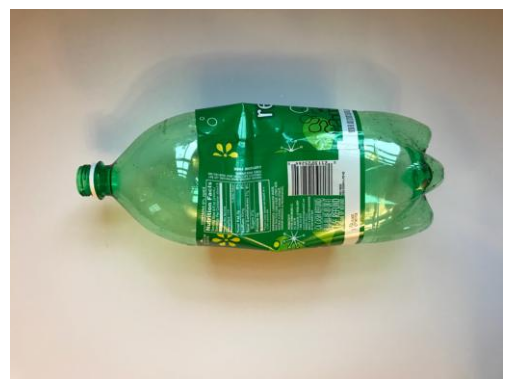

In [ ]:
base_path = 'dataset/processed'

# Get a list of only directories within the base path
all_folds = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Pick a random folder
fold_path = os.path.join(base_path, random.choice(all_folds))

# Pick a random file inside the chosen folder
img_path = os.path.join(fold_path, random.choice(os.listdir(fold_path)))

# Load and display the image
img = imageio.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


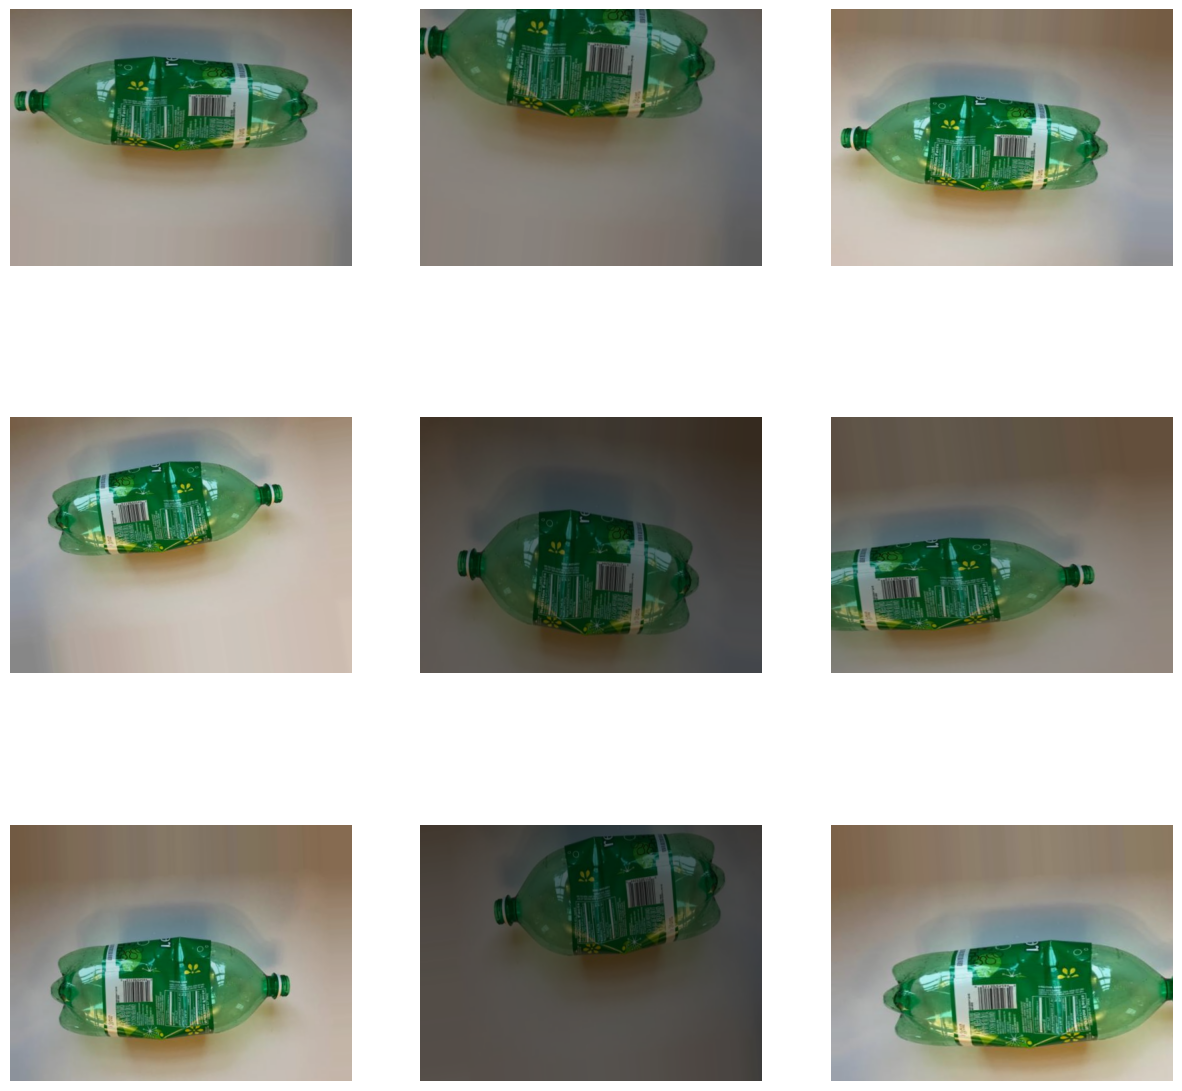

In [ ]:
img = img_to_array(img)
samples = np.expand_dims(img, 0)
img_batches = datagen.flow(samples, batch_size=1)

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = img_batches.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Modelling
Model Convolutional Neural Network (CNN) yang digunakan dibangun menggunakan TensorFlow dan Keras untuk klasifikasi gambar. Arsitektur yang diadopsi berbasis model ResNet50V2, yang merupakan varian dari arsitektur ResNet (Residual Network).

In [ ]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

train = datagen.flow_from_directory('dataset/processed',
                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                    batch_size=128,
                                    class_mode='binary',
                                    subset='training')

val = datagen.flow_from_directory('dataset/processed',
                                  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                  batch_size=128,
                                  class_mode='binary',
                                  subset='validation',
                                  shuffle=False)

Found 4928 images belonging to 8 classes.
Found 1224 images belonging to 8 classes.


In [ ]:
baseModel = tf.keras.applications.ResNet50V2(input_shape=(IMAGE_WIDTH,
                                                          IMAGE_HEIGHT,
                                                          IMAGE_CHANNELS),
                                             weights='imagenet',
                                             include_top=False,
                                             classes=train.num_classes)

baseModel.trainable = False

94668760/94668760 [==============================] - 27s 0us/step


In [ ]:
model = Sequential()
model.add(tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))


def ResNet50V2_preprocessing(img):
    return resnet_v2.preprocess_input(img)


model.add(Lambda(ResNet50V2_preprocessing))

model.add(baseModel)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(train.num_classes, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23581192 (89.96 MB)
Trainable params: 16392 (64.03 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
epochs = 10

history = model.fit_generator(train, validation_data=val, epochs=epochs)

Epoch 1/10
39/39 [==============================] - 233s 6s/step - loss: 0.9384 - accuracy: 0.6869 - val_loss: 0.4616 - val_accuracy: 0.8587
Epoch 2/10
39/39 [==============================] - 242s 6s/step - loss: 0.3682 - accuracy: 0.8799 - val_loss: 0.3484 - val_accuracy: 0.8864
Epoch 3/10
39/39 [==============================] - 270s 7s/step - loss: 0.2888 - accuracy: 0.9115 - val_loss: 0.3434 - val_accuracy: 0.8856
Epoch 4/10
39/39 [==============================] - 285s 7s/step - loss: 0.2475 - accuracy: 0.9207 - val_loss: 0.3013 - val_accuracy: 0.9036
Epoch 5/10
39/39 [==============================] - 257s 7s/step - loss: 0.2273 - accuracy: 0.9274 - val_loss: 0.2827 - val_accuracy: 0.9036
Epoch 6/10
39/39 [==============================] - 245s 6s/step - loss: 0.2023 - accuracy: 0.9389 - val_loss: 0.2795 - val_accuracy: 0.9085
Epoch 7/10
39/39 [==============================] - 249s 6s/step - loss: 0.1900 - accuracy: 0.9395 - val_loss: 0.2811 - val_accuracy: 0.8962
Epoch 8/10
39

# Evaluasi Model
Evaluasi model dilakukan untuk mengetahui apakah model sudah ideal, atau cenderung overfit/underfit. Evaluasi juga dilakukan menggunakan Confussion Matrix, Precision, F1, Recall, dan Support.

In [ ]:
model.evaluate(val)

10/10 [==============================] - 55s 5s/step - loss: 0.2701 - accuracy: 0.9085


[0.27006399631500244, 0.9084967374801636]

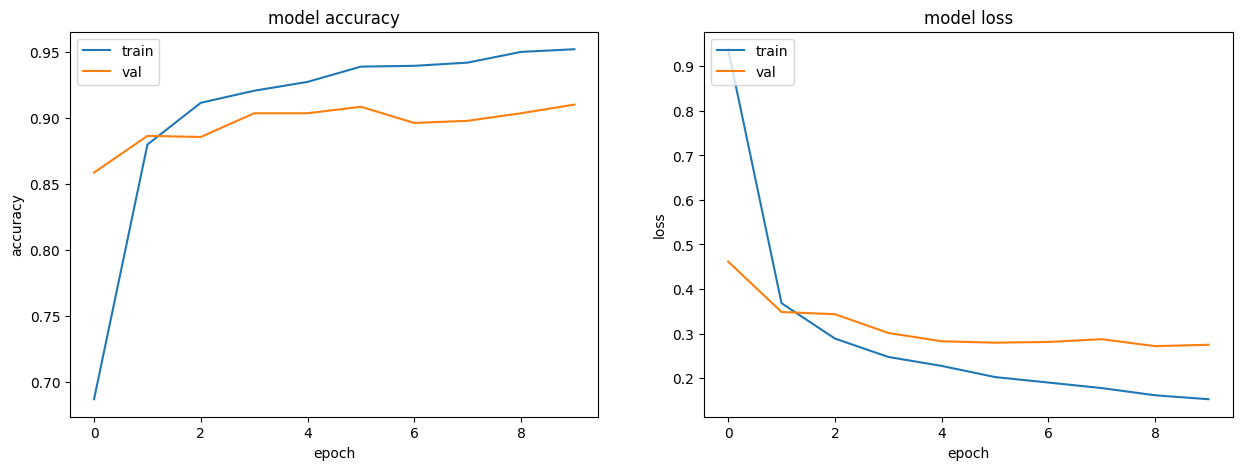

In [76]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [77]:
Y_pred = model.predict_generator(val)
y_pred = np.argmax(Y_pred, axis=1)

<Axes: >

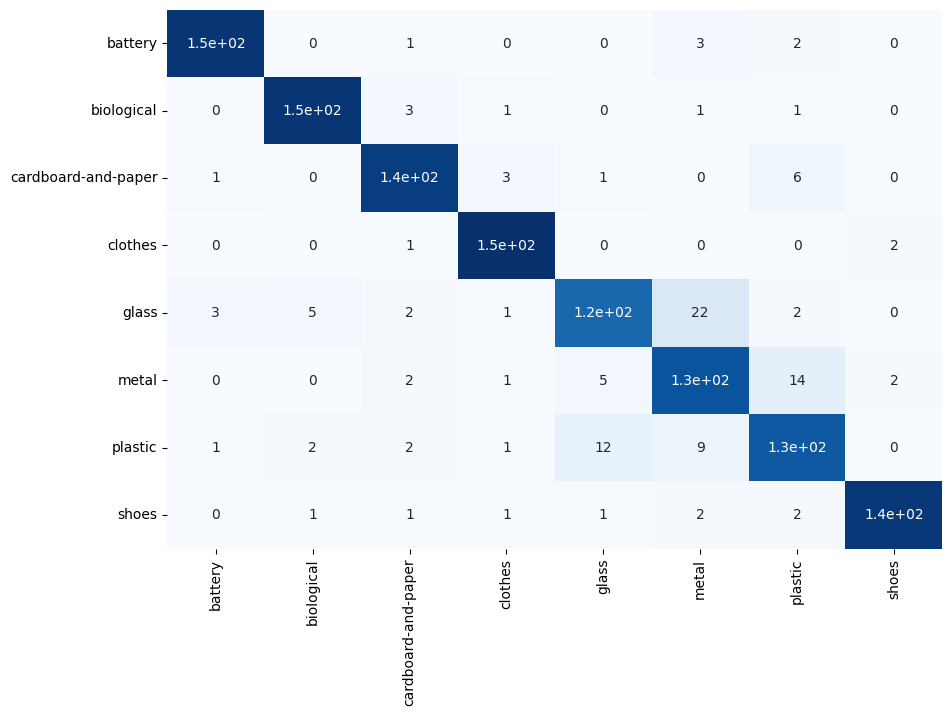

In [78]:
df_cm = pd.DataFrame(confusion_matrix(val.classes, y_pred), index = [i for i in val.class_indices.keys()],
                  columns = [i for i in val.class_indices.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", cbar=False)

In [79]:
print('Hasil Klasifikasi')
print(classification_report(val.classes, y_pred, target_names=val.class_indices.keys()))

Hasil Klasifikasi
                     precision    recall  f1-score   support

            battery       0.97      0.96      0.96       153
         biological       0.95      0.96      0.95       153
cardboard-and-paper       0.92      0.93      0.93       153
            clothes       0.95      0.98      0.96       153
              glass       0.86      0.77      0.81       153
              metal       0.78      0.84      0.81       153
            plastic       0.82      0.82      0.82       153
              shoes       0.97      0.95      0.96       153

           accuracy                           0.90      1224
          macro avg       0.90      0.90      0.90      1224
       weighted avg       0.90      0.90      0.90      1224

